**Adding libraries and dependencies**

In [53]:
import numpy as np
import tensorflow as tf

from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
from mlagents_envs.base_env import ActionTuple
from collections import deque

import tf_agents
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import array_spec

import matplotlib.pyplot as plt

Checking GPU detection

In [23]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Establishing connection with Unity environment**

In [24]:
engine_config_channel = EngineConfigurationChannel()

env = UnityEnvironment(
    file_name=None,
    worker_id=0,
    base_port=5004,
    side_channels=[engine_config_channel]
)

In [25]:
env.reset()
behavior_names = list(env.behavior_specs)
behavior_name = behavior_names[0]
behavior_spec = env.behavior_specs[behavior_name]

print(f"Behavior: {behavior_name}")
print(f"Action branches: {behavior_spec.action_spec.discrete_branches}")
print(f"Observation shapes: {[obs.shape for obs in behavior_spec.observation_specs]}")

decision_steps, terminal_steps = env.get_steps(behavior_name)
print(f"Active agents: {len(decision_steps)}")

Behavior: RobotBehaviour?team=0
Action branches: (5,)
Observation shapes: [(36,), (8,)]
Active agents: 1


### Action Space
- **5 discrete actions** corresponding to possible movements:
  - `0`: Do nothing
  - `1`: Go right  
  - `2`: Go left
  - `3`: Go forward
  - `4`: Go backwards

### Observation Space

#### Ray Perception (36 dimensions)
- **36 values** from ML-Agents Ray Perception Sensor 3D component
- Detects sphere tags and distances in the environment

#### Agent State (8 dimensions)
- **8 values** divided as follows:
  - Position: `x`, `y`, `z` coordinates
  - Velocity: `x`, `y`, `z` velocity components  
  - Rotation: `y`-axis rotation (facing direction)
  - Time: Elapsed time since episode start

**Total observation size:** 44

---

In [26]:
action_size = 5
state_size = 44

Preparing a get_state function for model training and inference, that is responsible for getting the agent's state at the current step and returning information which will later be used by the model :
- state (44,) : agent's state at the current step
- reward (float) : reward of the current step
- done (boolean) : whether the episode is terminated at the current step

In [27]:
def get_state():
    decision_steps, terminal_steps = env.get_steps(behavior_name)
    
    if len(decision_steps) > 0:
        obs1 = decision_steps.obs[0][0] #Ray perception sensor observations
        obs2 = decision_steps.obs[1][0] #Agent state observations
        state = np.concatenate([obs1, obs2]) #Combine observations for correct DQN input format
        return state, decision_steps.reward[0], False
    
    elif len(terminal_steps) > 0:
        # Episode ended
        obs1 = terminal_steps.obs[0][0]
        obs2 = terminal_steps.obs[1][0] 
        state = np.concatenate([obs1, obs2])
        return state, terminal_steps.reward[0], True
    
    return None, 0, False


**Making a random Neural Network**

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(state_size,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(action_size, activation='linear')
])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                2880      
                                                                 
 dense_13 (Dense)            (None, 128)               8320      
                                                                 
 dense_14 (Dense)            (None, 32)                4128      
                                                                 
 dense_15 (Dense)            (None, 5)                 165       
                                                                 
Total params: 15493 (60.52 KB)
Trainable params: 15493 (60.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
l1_weights = model.get_weights()[0]
l1_weights[:,0] #weights of the first neuron of the first layer

array([ 0.12881191, -0.05349946,  0.0935366 ,  0.09197785,  0.20343368,
        0.10075463, -0.1383694 ,  0.1697702 , -0.03485735,  0.06967925,
       -0.20340176, -0.03939438, -0.03095512,  0.15369894, -0.22063127,
        0.10697804, -0.19072337,  0.05371515, -0.22273828, -0.06253025,
       -0.20050858,  0.09067322,  0.10090114,  0.14284231, -0.19373435,
        0.22996522,  0.15430067, -0.02219802, -0.11690249,  0.19520639,
       -0.21624936, -0.14423747, -0.18991616, -0.19250663, -0.08125176,
        0.18753819,  0.1471392 , -0.09828235, -0.15206493,  0.08851804,
       -0.1677104 ,  0.01645143, -0.17666745, -0.15252185], dtype=float32)

Running the model with the initial random weights

In [31]:
for step in range(100): #Run for 100 steps
    state, reward, done = get_state()
    
    if state is not None:
        if done:
            env.reset()
        q_values = model.predict(np.expand_dims(state, axis=0), verbose=0)
        action = np.argmax(q_values[0])  # Choose best action
        
        if step % 10 == 0: 
            print(f"Step {step}: Action {action}, Reward {reward:.2f}")
        
        # Send action to Unity
        action_tuple = ActionTuple(discrete=np.array([[action]]))
        env.set_actions(behavior_name, action_tuple)
        env.step()
    else:
        env.close()
    

Step 0: Action 3, Reward 0.00
Step 10: Action 3, Reward 0.00
Step 20: Action 3, Reward 0.00
Step 30: Action 3, Reward 0.00
Step 40: Action 3, Reward 0.00
Step 50: Action 2, Reward 0.00
Step 60: Action 4, Reward 0.00
Step 70: Action 4, Reward 0.00
Step 80: Action 4, Reward 0.00
Step 90: Action 4, Reward 0.00


**Creating environment wrapper for TF agents**

In [32]:
class EnvironmentWrapper(py_environment.PyEnvironment):
    def __init__(self, unity_env, behavior_name):
        super().__init__()
        self.unity_env = unity_env
        self.behavior_name = behavior_name
        
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(),
            dtype=np.int32,
            minimum=0,
            maximum=4,
            name='action'
        )
        self._observation_spec = array_spec.ArraySpec(
            shape=(44,),
            dtype=np.float32,
            name='observation'
        )
        
        self._state = np.zeros(44, dtype=np.float32)
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self.unity_env.reset()
        self._episode_ended = False
        state, _, _ = get_state()
        if state is not None:
            self._state = state.astype(np.float32)
        return tf_agents.trajectories.time_step.restart(self._state)

    def _step(self, action):
        if self._episode_ended:
            return self.reset()
        
        # Send action to Unity
        action_tuple = ActionTuple(discrete=np.array([[action]]))
        self.unity_env.set_actions(self.behavior_name, action_tuple)
        self.unity_env.step()
        
        # Get new state
        state, reward, done = get_state()
        
        if state is not None:
            self._state = state.astype(np.float32)
        
        if done:
            self._episode_ended = True
            return tf_agents.trajectories.time_step.termination(self._state, reward)
        else:
            return tf_agents.trajectories.time_step.transition(self._state, reward)

In [33]:
env_wrapper = EnvironmentWrapper(env, behavior_name)
tf_env = tf_py_environment.TFPyEnvironment(env_wrapper)

**Setting the architecture of the Q-neural-networks**

In [34]:
q_net = q_network.QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=(64, 128, 32)
)

**Creating the agent (Deep-Q-Network)**

In [35]:
train_step_counter = tf.Variable(0)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    epsilon_greedy=0.1,
    target_update_period=100,
    gamma=0.99 
)

agent.initialize()

**Creating the replay buffer**

In [36]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=100000
)

**Creating policies**

In [37]:
eval_policy = agent.policy # greedy: for testing and inference
collect_policy = agent.collect_policy # Epsilon-greedy: for training and exploration
random_policy = random_tf_policy.RandomTFPolicy(  # Completely random: for initial data collection
    tf_env.time_step_spec(), 
    tf_env.action_spec()
)

**Data collection**

In [46]:
def collect_data(policy, steps, speed):
    engine_config_channel.set_configuration_parameters(time_scale=speed)
    tf_env.reset()
    for i in range(steps):
        time_step = tf_env.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = tf_env.step(action_step.action)
        traj = trajectory.from_transition(time_step, action_step, next_time_step)
        replay_buffer.add_batch(traj)
        if i % 100 == 0 and i > 0:
            print(f"Collected {i} steps")

Collecting initial data randomly

In [49]:
collect_data(random_policy, 1000, 10)

Collected 100 steps
Collected 200 steps
Collected 300 steps
Collected 400 steps
Collected 500 steps
Collected 600 steps
Collected 700 steps
Collected 800 steps
Collected 900 steps


**Actual training**

In [44]:
num_iterations = 10000
collect_steps_per_iteration = 4
batch_size = 64
eval_interval = 200

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2
).prefetch(3)

iterator = iter(dataset)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [50]:
train_losses = []
episode_returns = []

for iteration in range(num_iterations):
    #collect data for 4 steps
    collect_data(collect_policy, collect_steps_per_iteration, 10)

    # Sample a random batch from the replay buffer and train the agent
    experience, _ = next(iterator)
    train_loss = agent.train(experience).loss
    
    training_step = agent.train_step_counter.numpy()

    # Log and evaluate each 200 training step
    if training_step % eval_interval == 0:
        print(f'Training step {training_step}: Loss = {train_loss:.4f} | Env step = {iteration * collect_steps_per_iteration}')
        train_losses.append(train_loss.numpy())
        
        time_step = tf_env.reset()
        episode_return = 0.0
        steps_in_episode = 0

        while not time_step.is_last() and steps_in_episode < 500:
            action_step = eval_policy.action(time_step)
            time_step = tf_env.step(action_step.action)
            episode_return += time_step.reward
            steps_in_episode += 1
            
        episode_returns.append(episode_return.numpy()[0])
        print(f'Evaluation episode Return: {episode_return.numpy()[0]:.2f}')

print("Training complete")

Training step 200: Loss = 0.0121 | Env step = 568
Evaluation episode Return: 0.00
Training step 400: Loss = 0.0031 | Env step = 1368
Evaluation episode Return: -5.00
Training step 600: Loss = 0.0087 | Env step = 2168
Evaluation episode Return: -5.00
Training step 800: Loss = 0.0025 | Env step = 2968
Evaluation episode Return: -5.00
Training step 1000: Loss = 0.0015 | Env step = 3768
Evaluation episode Return: -5.00
Training step 1200: Loss = 0.0007 | Env step = 4568
Evaluation episode Return: -5.00
Training step 1400: Loss = 0.0009 | Env step = 5368
Evaluation episode Return: 0.00
Training step 1600: Loss = 0.0008 | Env step = 6168
Evaluation episode Return: 0.00
Training step 1800: Loss = 0.0005 | Env step = 6968
Evaluation episode Return: -5.00
Training step 2000: Loss = 0.0011 | Env step = 7768
Evaluation episode Return: -5.00
Training step 2200: Loss = 0.0009 | Env step = 8568
Evaluation episode Return: -5.00
Training step 2400: Loss = 0.0020 | Env step = 9368
Evaluation episode Re

**Model evaluation**

Visualizing training information

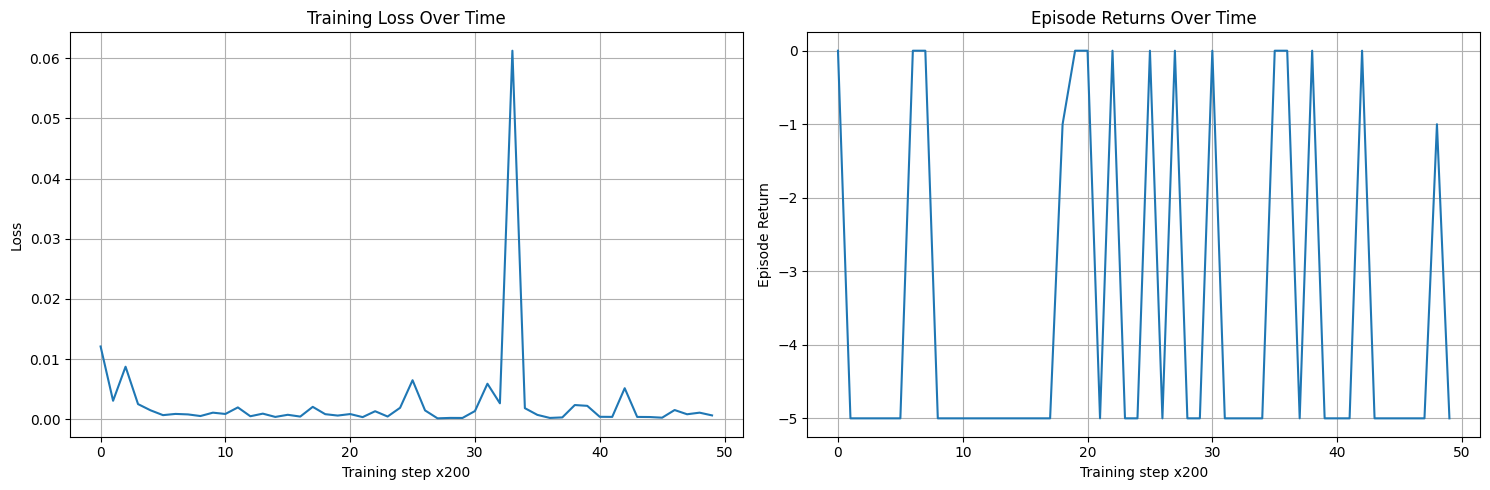

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses)
ax1.set_title('Training Loss Over Time')
ax1.set_xlabel('Training step x200')
ax1.set_ylabel('Loss')
ax1.grid(True)

ax2.plot(episode_returns)
ax2.set_title('Episode Returns Over Time')
ax2.set_xlabel('Training step x200')
ax2.set_ylabel('Episode Return')
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_progress.png', dpi=300, bbox_inches='tight')
plt.show()